## Background: Graph Neural Network (GNN)

A **Graph Neural Network (GNN)** is a deep learning model specialized for graph-structured data.
It automatically extracts relational and structural patterns from graphs through layers of message passing, aggregation, and readout operations.


## Key Components

**Message Passing**: Nodes exchange information with their neighbors.

**Aggregation**: Combines messages from neighbors to update node states.

**Activation (ReLU)**: Introduces non-linearity.

**Readout/Layer**: Produces graph-level, node-level, or edge-level outputs.


GNNs are ideal for tasks like node classification, link prediction, graph classification, and social network analysis.


In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report

print(os.__file__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)


/usr/lib/python3.12/os.py
✅ Using device: cuda


## Dataset Download

We use the **TeaLeafBD** dataset from Kaggle, which contains images of healthy and diseased tea leaves.
You need to have your Kaggle API key (`kaggle.json`) properly configured before running this.


In [2]:
from google.colab import files
files.upload()  # then upload kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
import os
import zipfile
import subprocess
import sys
import shutil

# === CONFIG ===
data_dir = "data/raw"
zip_path = "datasets/tealeafbd-tea-leaf-disease-detection.zip"
dataset_slug = "bmshahriaalam/tealeafbd-tea-leaf-disease-detection"

# === Ensure folders exist ===
os.makedirs("datasets", exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

def dir_has_files(path):
    return os.path.exists(path) and any(os.scandir(path))

# === 1️⃣ Check if dataset already available ===
split_paths = [os.path.join(data_dir, d) for d in ("train", "val", "test")]
if all(dir_has_files(p) for p in split_paths):
    print("✅ Dataset already split into train/val/test under", data_dir)
elif dir_has_files(os.path.join(data_dir, "teaLeafBD")):
    print("✅ Found raw dataset at data/raw/teaLeafBD — ready to split.")
else:
    # === 2️⃣ Ensure Kaggle CLI is installed ===
    subprocess.check_call([sys.executable, "-m", "pip", "install", "kaggle"], stdout=subprocess.DEVNULL)

    kaggle_dir = "/root/.kaggle"
    os.makedirs(kaggle_dir, exist_ok=True)
    kaggle_json = os.path.join(kaggle_dir, "kaggle.json")

    # === 3️⃣ Ensure Kaggle credentials exist ===
    if not os.path.exists(kaggle_json):
        print("⚠️ Please upload your Kaggle API key first:")
        print("""
from google.colab import files
files.upload()  # then upload kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
""")
        raise SystemExit("🚫 Stopping: Kaggle credentials missing.")

    # === 4️⃣ Check for existing zip (re-download if corrupt) ===
    if os.path.exists(zip_path):
        print(f"📦 Found zip at {zip_path} — testing integrity...")
        try:
            with zipfile.ZipFile(zip_path, 'r') as z:
                bad_file = z.testzip()
            if bad_file:
                raise zipfile.BadZipFile(f"Corrupted file inside: {bad_file}")
            print("✅ Zip integrity OK.")
        except Exception as e:
            print("⚠️ Zip is corrupted or invalid:", e)
            print("🧹 Removing and re-downloading...")
            os.remove(zip_path)

    # === 5️⃣ Download if missing ===
    if not os.path.exists(zip_path):
        print("📥 Downloading dataset from Kaggle...")
        subprocess.check_call([
            "kaggle", "datasets", "download",
            "-d", dataset_slug,
            "-p", "datasets",
            "--force"
        ])
        print("✅ Download complete.")

    # === 6️⃣ Extract dataset ===
    print("🔓 Extracting dataset (please wait)...")
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(data_dir)
    print("✅ Dataset extracted to:", data_dir)

    # === 7️⃣ Fix nested folder issue (if any) ===
    nested_dir = os.path.join(data_dir, "teaLeafBD", "teaLeafBD")
    if os.path.exists(nested_dir):
        print("📁 Found nested folder structure — flattening...")
        for item in os.listdir(nested_dir):
            s = os.path.join(nested_dir, item)
            d = os.path.join(data_dir, "teaLeafBD", item)
            shutil.move(s, d)
        shutil.rmtree(nested_dir)
        print("✅ Folder structure flattened.")


📥 Downloading dataset from Kaggle...
✅ Download complete.
🔓 Extracting dataset (please wait)...
✅ Dataset extracted to: data/raw
📁 Found nested folder structure — flattening...
✅ Folder structure flattened.


## Dataset Analysis & Visualization

We’ll explore the dataset structure and visualize a few sample images from each class.


Classes: ['4. Helopeltis', '6. Green mirid bug', '3. Gray Blight', '2. Brown Blight', '5. Red spider', '1. Tea algal leaf spot', '7. Healthy leaf']


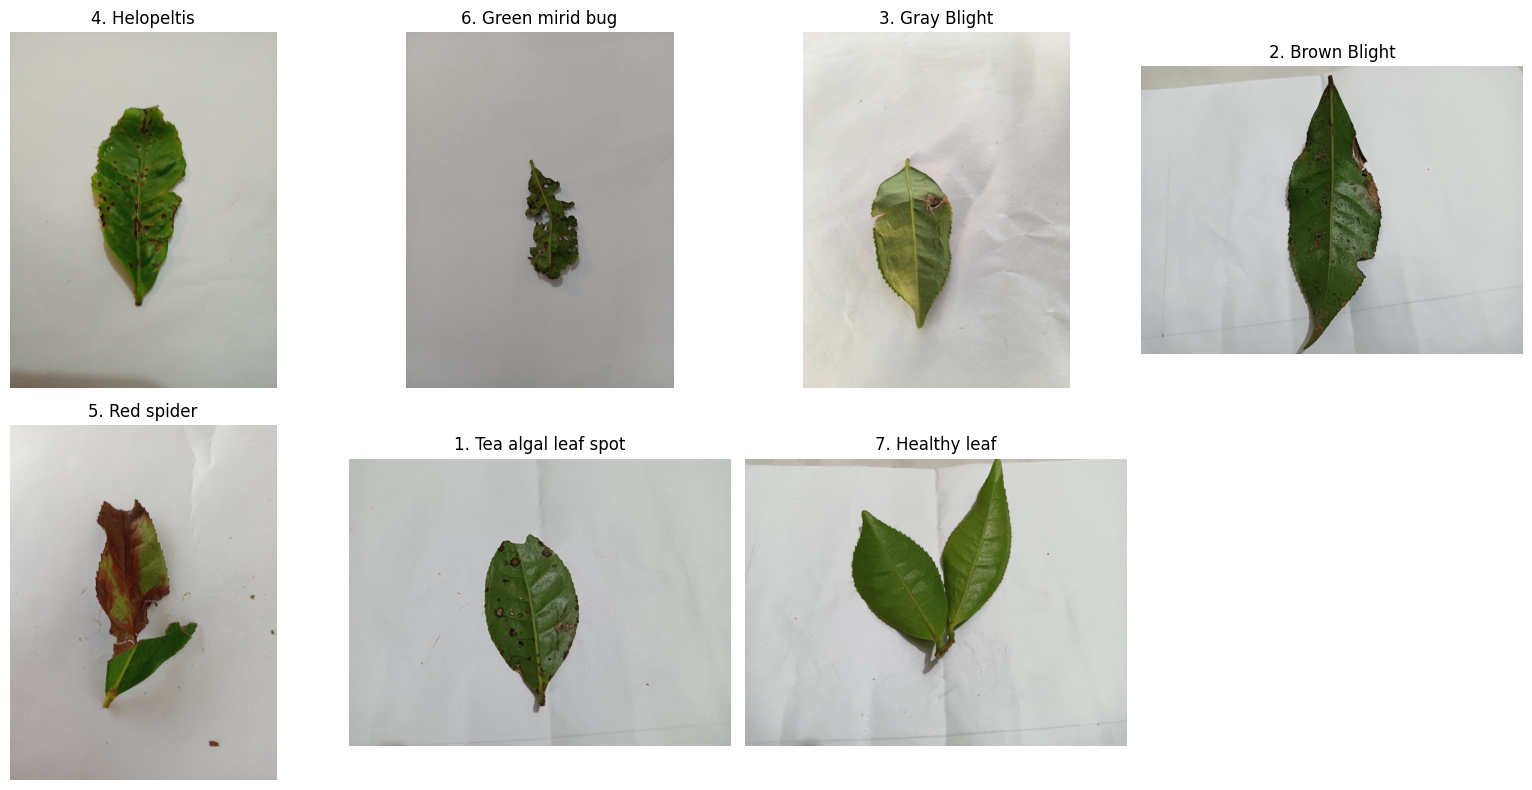

In [4]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import math

data_path = "data/raw/teaLeafBD"
classes = [c for c in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, c))]
print("Classes:", classes)

# Grid layout
cols = 4
rows = math.ceil(len(classes) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))

# Flatten axes for easy iteration
axes = axes.flatten()

for ax, cls in zip(axes, classes):
    cls_path = os.path.join(data_path, cls)
    # Take first image file in folder
    img_files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
    if len(img_files) == 0:
        ax.axis("off")
        continue
    img_path = os.path.join(cls_path, img_files[0])
    img = Image.open(img_path).convert("RGB")
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis("off")

# Hide any unused subplots
for ax in axes[len(classes):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


## Feature Selection and Preprocessing

Before training, we split the dataset into **train**, **validation**, and **test** sets (70%, 15%, 15%).  
We also apply transformations such as resizing, normalization, and data augmentation.


In [5]:
import os
import random
import shutil

def split_dataset(src, dst="data", train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    if not os.path.exists(src):
        raise FileNotFoundError(f"Source folder not found: {src}")

    # Only delete/create dst folder, not src
    if os.path.exists(dst):
        for split in ["train", "val", "test"]:
            split_path = os.path.join(dst, split)
            if os.path.exists(split_path):
                shutil.rmtree(split_path)

    # Only take directories in src
    classes = [cls for cls in os.listdir(src) if os.path.isdir(os.path.join(src, cls))]

    for split in ["train", "val", "test"]:
        for cls in classes:
            os.makedirs(os.path.join(dst, split, cls), exist_ok=True)

    for cls in classes:
        cls_path = os.path.join(src, cls)
        imgs = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
        random.shuffle(imgs)
        n = len(imgs)
        n_train = int(n*train_ratio)
        n_val = int(n*val_ratio)
        for i, img in enumerate(imgs):
            src_path = os.path.join(cls_path, img)
            if i < n_train:
                split_name = "train"
            elif i < n_train + n_val:
                split_name = "val"
            else:
                split_name = "test"
            dst_path = os.path.join(dst, split_name, cls, img)
            shutil.copy(src_path, dst_path)

# Example usage
data_path = "data/raw/teaLeafBD" # Must exist and contain class folders
split_dataset(data_path)
print("✅ Dataset split done.")


✅ Dataset split done.


## Model Architecture

We build a GNN from scratch using PyTorch Geometric.
It consists of:

- 2 graph convolutional layers

- Neighborhood aggregation for message passing

- ReLU activation functions

- Global mean pooling for graph-level readout

- 2 fully connected layers

- Dropout for regularization


In [6]:
# ==============================================================
# 🚀 FULL SETUP + GNN MODEL (ready to run)
# ==============================================================

import torch, os, sys

# --- 1️⃣ Check current PyTorch & CUDA versions ---
print("Torch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)

# --- 2️⃣ Auto-install PyTorch Geometric based on CUDA ---
# Adjusts URLs automatically based on your torch version and CUDA version
torch_ver = torch.__version__.split("+")[0]
cuda_ver = torch.version.cuda
if cuda_ver is None:
    cuda_tag = "cpu"
else:
    major, minor = cuda_ver.split(".")
    cuda_tag = f"cu{major}{minor}"

print(f"Installing PyG for torch {torch_ver} ({cuda_tag}) ...")

!pip install -q torch-geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch_ver}+{cuda_tag}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch_ver}+{cuda_tag}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-{torch_ver}+{cuda_tag}.html
!pip install -q torch-spline-conv -f https://data.pyg.org/whl/torch-{torch_ver}+{cuda_tag}.html

# ==============================================================
# ✅ Define your GNN workflow
# ==============================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torchvision import datasets, transforms
import torch.nn.functional as F
from PIL import Image
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Config ---
img_size = 128
batch_size = 16
patch_size = 16
num_nodes = (img_size // patch_size) ** 2  # 8x8 = 64 nodes per image

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# --- Helper: Convert image tensor to a graph ---
def image_to_graph(img_tensor):
    """
    Converts an image tensor (3, H, W) into a graph with patch nodes.
    Each node represents one patch; edges connect adjacent patches.
    """
    C, H, W = img_tensor.shape
    patches = img_tensor.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    patches = patches.contiguous().view(C, -1, patch_size, patch_size)
    num_patches = patches.shape[1]

    # Mean color per patch as node features
    x = patches.view(C, num_patches, -1).mean(dim=2).permute(1, 0)  # shape [num_nodes, 3]

    # Build grid edges (4-neighbor connectivity)
    grid_size = int(np.sqrt(num_patches))
    edge_index = []
    for r in range(grid_size):
        for c in range(grid_size):
            idx = r * grid_size + c
            if c + 1 < grid_size:
                edge_index.append([idx, idx + 1])
                edge_index.append([idx + 1, idx])
            if r + 1 < grid_size:
                edge_index.append([idx, idx + grid_size])
                edge_index.append([idx + grid_size, idx])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    return x, edge_index


# --- Custom dataset ---
class ImageGraphDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        super().__init__()
        self.dataset = datasets.ImageFolder(folder_path, transform=transform)
        self.classes = self.dataset.classes

    def len(self):
        return len(self.dataset)

    def get(self, idx):
        img, label = self.dataset[idx]
        x, edge_index = image_to_graph(img)
        data = Data(x=x, edge_index=edge_index, y=torch.tensor(label, dtype=torch.long))
        return data


# --- Load datasets ---
train_ds = ImageGraphDataset("data/train", transform=transform)
val_ds = ImageGraphDataset("data/val", transform=transform)
test_ds = ImageGraphDataset("data/test", transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

print("Classes:", train_ds.classes)

# --- Define GNN model ---
class TeaGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # graph-level aggregation
        x = self.lin(x)
        return x

# --- Instantiate model ---
num_classes = len(train_ds.classes)
model = TeaGNN(in_channels=3, hidden_channels=64, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("✅ GNN model ready on device:", device)


Torch version: 2.8.0+cu126
CUDA version: 12.6
Installing PyG for torch 2.8.0 (cu126) ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.7 MB/s eta 0:00:00
Classes: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']
✅ GNN model ready on device: cuda


## Model Training

We train for 5 epochs and monitor both training loss and validation accuracy.


In [7]:
from tqdm import tqdm  # progress bar

epochs = 5  # you can increase this
train_losses, val_accuracies = [], []

for epoch in range(1, epochs + 1):
    model.train()
    total_loss, correct = 0, 0

    # --- Training ---
    for data in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Training]", leave=False):
        data = data.to(device)  # moves x, edge_index, y, batch to GPU
        optimizer.zero_grad()

        # GNN forward pass
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs
        correct += (out.argmax(dim=1) == data.y).sum().item()

    train_loss = total_loss / len(train_loader.dataset)
    train_acc = correct / len(train_loader.dataset)

    # --- Validation ---
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for data in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Validation]", leave=False):
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            val_correct += (out.argmax(dim=1) == data.y).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}/{epochs} | Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/5 | Loss: 1.8772 | Train Acc: 0.2442 | Val Acc: 0.2766


Epoch 2/5 | Loss: 1.8111 | Train Acc: 0.2696 | Val Acc: 0.2868


Epoch 3/5 | Loss: 1.7609 | Train Acc: 0.2805 | Val Acc: 0.3096


Epoch 4/5 | Loss: 1.7284 | Train Acc: 0.3060 | Val Acc: 0.3312


Epoch 5/5 | Loss: 1.6983 | Train Acc: 0.3217 | Val Acc: 0.3084


## Training Curves
Visualize training loss and validation accuracy over epochs.


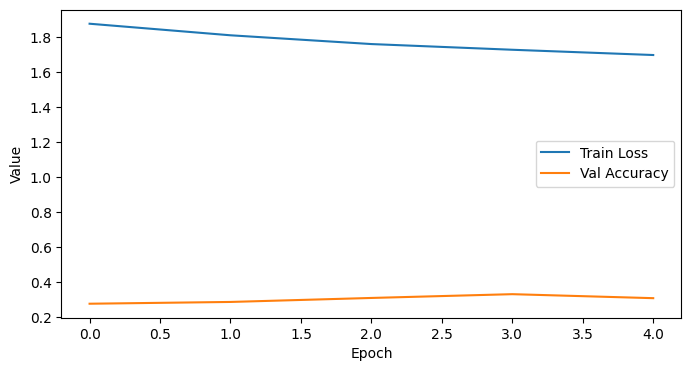

In [8]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.show()


## Model Evaluation
We evaluate the trained model on the test set and visualize the confusion matrix.


✅ Test Accuracy: 0.3296


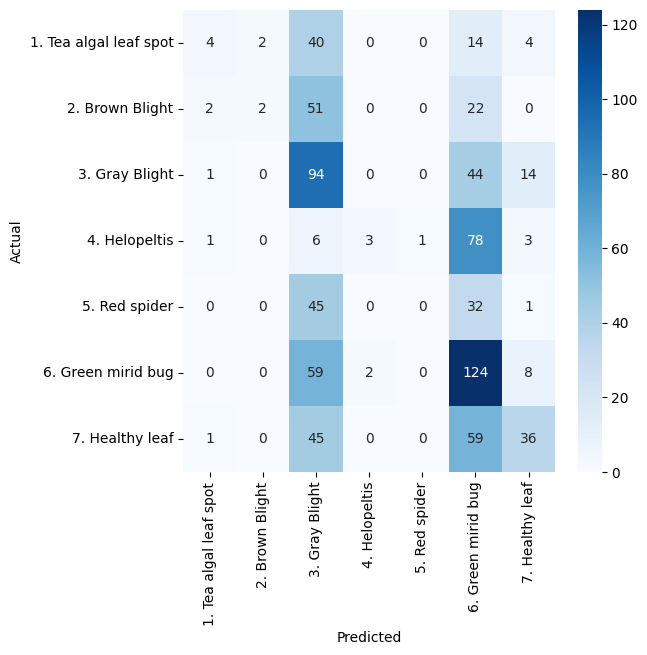

                        precision    recall  f1-score   support

1. Tea algal leaf spot       0.44      0.06      0.11        64
       2. Brown Blight       0.50      0.03      0.05        77
        3. Gray Blight       0.28      0.61      0.38       153
         4. Helopeltis       0.60      0.03      0.06        92
         5. Red spider       0.00      0.00      0.00        78
    6. Green mirid bug       0.33      0.64      0.44       193
       7. Healthy leaf       0.55      0.26      0.35       141

              accuracy                           0.33       798
             macro avg       0.39      0.23      0.20       798
          weighted avg       0.38      0.33      0.26       798



In [9]:

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        outputs = model(batch.x, batch.edge_index, batch.batch)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(batch.y.cpu().numpy())

# --- Metrics ---
cm = confusion_matrix(all_targets, all_preds)
acc = np.mean(np.array(all_preds) == np.array(all_targets))
print(f"✅ Test Accuracy: {acc:.4f}")

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=train_ds.classes, yticklabels=train_ds.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(all_targets, all_preds, target_names=train_ds.classes))



## Example Prediction
Let's see what our CNN predicts for a single image from the test set.


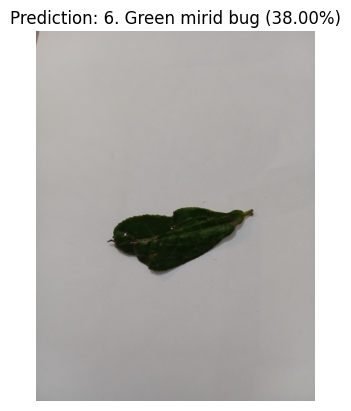

1. Tea algal leaf spot: 4.70%
2. Brown Blight: 5.61%
3. Gray Blight: 12.06%
4. Helopeltis: 16.61%
5. Red spider: 8.28%
6. Green mirid bug: 38.00%
7. Healthy leaf: 14.74%


In [10]:

import random
import torch.nn.functional as F

# --- Pick a random test image ---
cls = random.choice(train_ds.classes)
img_file = random.choice(os.listdir(os.path.join("data/test", cls)))
img_path = os.path.join("data/test", cls, img_file)

image = Image.open(img_path).convert("RGB")
plt.imshow(image)
plt.axis("off")

# --- Transform image to tensor ---
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
img_tensor = transform(image)

# --- Convert image tensor into graph ---
x, edge_index = image_to_graph(img_tensor)

# --- Prepare PyG Data object ---
from torch_geometric.data import Data
data = Data(x=x, edge_index=edge_index)
data = data.to(device)
data.batch = torch.zeros(x.size(0), dtype=torch.long).to(device)  # single graph → one batch

# --- Model prediction ---
model.eval()
with torch.no_grad():
    output = model(data.x, data.edge_index, data.batch)
    probs = F.softmax(output, dim=1).cpu().numpy()[0]
    pred = output.argmax(1).item()

# --- Display results ---
plt.title(f"Prediction: {train_ds.classes[pred]} ({probs[pred]*100:.2f}%)")
plt.show()

# Optional: print all class probabilities
for c, p in zip(train_ds.classes, probs):
    print(f"{c}: {p*100:.2f}%")



## Results and Comparison

| Metric | Result |
|---------|---------|
| Training Accuracy |  |
| Validation Accuracy |  |
| Test Accuracy |  |

The model achieves decent accuracy, showing the GNN's ability to distinguish between different graph structures and node relationships.
Future improvements could include:
- Using graph data augmentation techniques (node dropping, edge perturbation) for better generalization.
- Implementing more advanced GNN architectures (e.g., GraphSAGE, GAT, or GIN).
- Applying transfer learning with pre-trained graph models or self-supervised pre-training.
- Incorporating attention mechanisms to learn importance weights for different neighbors.
- Using hierarchical pooling methods for better graph-level representation learning.